In [1]:
import pandas as pd
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import scipy


In [2]:
df = pd.read_csv('../Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_gmt("../Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")

In [14]:
df = pd.read_csv('../Data/Su_COVID_proteomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = '../Data/UniProt2Reactome_all_Levels_ver84.txt', download_latest = False, filepath = None)

In [15]:
#Convert pathway ID to name
root_path = pd.read_excel('../Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Remove root pathways
reactome_pathways = reactome_pathways[~reactome_pathways.index.isin(root_pathway_names)]

In [16]:
for i in range(len(df.index)):
    if df.WHO_status[i] == '1-2':
        df['Group'][i] = 'Mild'
    else:
        df['Group'][i] = 'Severe'


C:\Users\jenna\AppData\Local\Temp\ipykernel_44940\897059123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'][i] = 'Severe'
C:\Users\jenna\AppData\Local\Temp\ipykernel_44940\897059123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'][i] = 'Mild'


### Over-representation analysis

In [17]:
#Initiate an ORA object 
ora = sspa.sspa_ora(df.iloc[:,:-2], df["Group"], reactome_pathways, 0.05, custom_background=None)
#Carry out ORA
ora_res = ora.over_representation_analysis()
print(len(ora.DA_molecules))
display(ora.DA_test_res.sort_values(by="P-value"))
display(ora_res.sort_values(by="P-value"))


top_10_pathways = ora_res.sort_values(by="P-value").iloc[0:10, :]

309


,Entity,P-value,P-adjust
36,P26022,3.443423e-24,1.563314e-21
19,P07711,2.699109e-22,6.126978e-20
250,Q8NHJ6,5.495219e-21,8.316098e-19
198,P15514,1.475977e-20,1.675234e-18
270,Q9UQV4,7.344087e-20,6.668431e-18
...,...,...,...
203,P19474,9.568247e-01,9.645644e-01
385,P09769,9.581906e-01,9.645644e-01
442,Q9NXA8,9.616541e-01,9.659092e-01
241,Q15517,9.718159e-01,9.739612e-01


,ID,Pathway_name,Hits,Coverage,P-value,P-adjust
506,R-HSA-9694516,SARS-CoV-2 Infection,11/11,11/316,0.013701,0.995481
450,R-HSA-9006934,Signaling by Receptor Tyrosine Kinases,33/40,40/543,0.026543,0.995481
85,R-HSA-177929,Signaling by EGFR,9/9,9/52,0.030179,0.995481
31,R-HSA-1280218,Adaptive Immune System,38/48,48/879,0.053581,0.995481
88,R-HSA-180292,GAB1 signalosome,7/7,7/17,0.066188,0.995481
...,...,...,...,...,...,...
169,R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831
451,R-HSA-9006936,Signaling by TGFB family members,2/7,7/122,0.994923,0.996831
52,R-HSA-162906,HIV Infection,1/5,5/245,0.996831,0.996831
53,R-HSA-162909,Host Interactions of HIV factors,1/5,5/144,0.996831,0.996831


In [18]:
#Change name to have a line break otherwise it won't fit on the plot
top_10_pathways.Pathway_name[62] = '\n Transport of inorganic cations/anions and \n amino acids/oligopeptides   '

['11', '316']
['40', '543']
['9', '52']
['48', '879']
['7', '17']
['16', '509']
['16', '125']
['16', '118']
['6', '145']
['6', '114']
['  3.5%', '  7.4%', '  17.3%', '  5.5%', '  41.2%', '  3.1%', '  12.8%', '  13.6%', '  4.1%', '  5.3%']


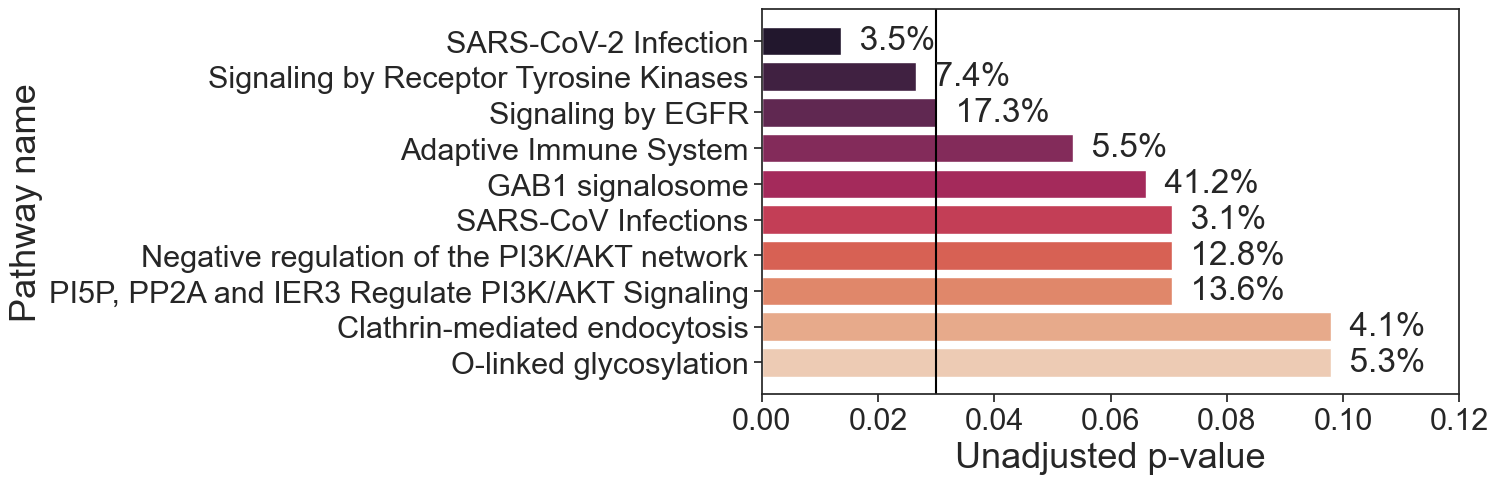

In [23]:

plt.figure(figsize=(9, 5))

sns.set(font_scale = 2)
sns.set_style("ticks") # same as "white" but with ticks

#If you want to colour by significance
#bar_color = ['tab:green' if float(i) < 0.05 else 'tab:grey' for i in top_20_pathways['P-value']]
#sns.barplot(data=top_10_pathways, y="Pathway_name", x="P-value", orient="h", palette=bar_color) #rocket, magma

#If you want to colour by gradient
ax = sns.barplot(data=top_10_pathways, y="Pathway_name", x="P-value", orient="h", palette="rocket",dodge=False, width=0.8) #rocket, magma

#Increase space between the bars and the axis
ax.relim()
ax.autoscale_view()


#Add pathway coverage
label = []
for i in top_10_pathways.Coverage:
    num = i.split('/')
    print(num)
    percent = (int(num[0]) / int(num[1])) *100
    label.append("  "+ str(round(percent,1))+ '%')

print(label)

ax.bar_label(ax.containers[0], labels=label)

#plt.title('Metabolomics',fontsize=22,pad=10)
plt.xlabel('Unadjusted p-value',fontsize=26)
plt.ylabel('Pathway name',fontsize=26) 
plt.xlim(0, 0.12)


plt.axvline(0.03, c="black")


#plt.savefig( '../Figures/proteomic_ORA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
list(top_10_pathways.Coverage)

For integrated data, take the two ORA results and combine the p-values with Fisher's method, which is what is commonly done (See Maghsoudi et al., 2021 for examples):

In [13]:
metabolomic_ora = ora_res.sort_values(by="P-value")

In [24]:
proteomic_ora = ora_res.sort_values(by="P-value")

In [25]:
metabolomic_ora.index = metabolomic_ora["ID"]
metabolomic_ora.drop(columns = ["ID"]) #using Sara's code to drop root pathways

,Pathway_name,Hits,Coverage,P-value,P-adjust
ID,,,,,
R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896
R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896
R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896
R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896
R-HSA-6814848,Glycerophospholipid catabolism,3/3,3/12,0.196449,0.997896
...,...,...,...,...,...
R-HSA-425397,"Transport of vitamins, nucleosides, and relate...",6/16,16/66,0.975858,0.997896
R-HSA-5619115,Disorders of transmembrane transporters,6/17,17/102,0.986544,0.997896
R-HSA-211859,Biological oxidations,5/16,16/335,0.993782,0.997896


In [26]:
proteomic_ora.index = proteomic_ora["ID"]
proteomic_ora.drop(columns = ["ID"]) #using Sara's code to drop root pathways

,Pathway_name,Hits,Coverage,P-value,P-adjust
ID,,,,,
R-HSA-9694516,SARS-CoV-2 Infection,11/11,11/316,0.013701,0.995481
R-HSA-9006934,Signaling by Receptor Tyrosine Kinases,33/40,40/543,0.026543,0.995481
R-HSA-177929,Signaling by EGFR,9/9,9/52,0.030179,0.995481
R-HSA-1280218,Adaptive Immune System,38/48,48/879,0.053581,0.995481
R-HSA-180292,GAB1 signalosome,7/7,7/17,0.066188,0.995481
...,...,...,...,...,...
R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831
R-HSA-9006936,Signaling by TGFB family members,2/7,7/122,0.994923,0.996831
R-HSA-162906,HIV Infection,1/5,5/245,0.996831,0.996831


In [27]:
result = metabolomic_ora.merge(proteomic_ora, how='inner',right_index=True, left_index = True)
result[:5]

,ID_x,Pathway_name_x,Hits_x,Coverage_x,P-value_x,P-adjust_x,ID_y,Pathway_name_y,Hits_y,Coverage_y,P-value_y,P-adjust_y
ID,,,,,,,,,,,,
R-HSA-428157,R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896,R-HSA-428157,Sphingolipid metabolism,1/3,3/91,0.967880,0.995481
R-HSA-597592,R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896,R-HSA-597592,Post-translational protein modification,27/38,38/1429,0.415531,0.995481
R-HSA-71291,R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896,R-HSA-71291,Metabolism of amino acids and derivatives,5/9,9/376,0.877946,0.995481
R-HSA-196854,R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896,R-HSA-196854,Metabolism of vitamins and cofactors,5/7,7/192,0.602981,0.995481
R-HSA-2262752,R-HSA-2262752,Cellular responses to stress,3/3,3/96,0.196449,0.997896,R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831


In [28]:
result["combined_pval"] = 0

In [29]:
for i in range(len(result.index)):
    ID_list = [result["P-value_x"][i],result["P-value_y"][i]]
    print(ID_list)
    test_stat,pval = scipy.stats.combine_pvalues(ID_list, method='fisher',weights=None)
    print(pval)
    result["combined_pval"][i] = pval


[0.1137023351415664, 0.9678801105310432]
0.3529110975440537
[0.1137023351415664, 0.4155308576440762]
0.1914616195792399
[0.12775205604398326, 0.877946285088071]
0.3575456658681867
[0.1343381968096432, 0.602980921134584]
0.2845862649756502
[0.19644906071579532, 0.9934574619687095]
0.5140450456158481
[0.19644906071579532, 0.7596623655120013]
0.43311466729161074
[0.30585582553278495, 0.4627592846515155]
0.4182705271707572
[0.3386699952965013, 0.8984741955246959]
0.6663218964970365
[0.3386699952965013, 0.8114854487167407]
0.6297956704874301
[0.3386699952965013, 0.9621094507142552]
0.691217610372946
[0.3386699952965013, 0.7596623655120013]
0.6065538386065297
[0.3386699952965013, 0.4627592846515155]
0.4471732904989808
[0.3386699952965013, 0.9850621546720174]
0.6998423567810675
[0.3386699952965013, 0.7596623655120013]
0.6065538386065297
[0.3386699952965013, 0.4627592846515155]
0.4471732904989808
[0.5022997073002744, 0.944690353450793]
0.8282499280951756
[0.5079684907308655, 0.1526681101543027

C:\Users\jenna\AppData\Local\Temp\ipykernel_44940\54959011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["combined_pval"][i] = pval


In [30]:
result[:10]

,ID_x,Pathway_name_x,Hits_x,Coverage_x,P-value_x,P-adjust_x,ID_y,Pathway_name_y,Hits_y,Coverage_y,P-value_y,P-adjust_y,combined_pval
ID,,,,,,,,,,,,,
R-HSA-428157,R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896,R-HSA-428157,Sphingolipid metabolism,1/3,3/91,0.967880,0.995481,0.352911
R-HSA-597592,R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896,R-HSA-597592,Post-translational protein modification,27/38,38/1429,0.415531,0.995481,0.191462
R-HSA-71291,R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896,R-HSA-71291,Metabolism of amino acids and derivatives,5/9,9/376,0.877946,0.995481,0.357546
R-HSA-196854,R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896,R-HSA-196854,Metabolism of vitamins and cofactors,5/7,7/192,0.602981,0.995481,0.284586
R-HSA-2262752,R-HSA-2262752,Cellular responses to stress,3/3,3/96,0.196449,0.997896,R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831,0.514045
R-HSA-196849,R-HSA-196849,Metabolism of water-soluble vitamins and cofac...,3/3,3/141,0.196449,0.997896,R-HSA-196849,Metabolism of water-soluble vitamins and cofac...,2/3,3/127,0.759662,0.995481,0.433115
R-HSA-1483257,R-HSA-1483257,Phospholipid metabolism,4/5,5/113,0.305856,0.997896,R-HSA-1483257,Phospholipid metabolism,2/2,2/211,0.462759,0.995481,0.418271
R-HSA-2151201,R-HSA-2151201,Transcriptional activation of mitochondrial bi...,2/2,2/16,0.338670,0.997896,R-HSA-2151201,Transcriptional activation of mitochondrial bi...,1/2,2/57,0.898474,0.995481,0.666322
R-HSA-2187338,R-HSA-2187338,Visual phototransduction,2/2,2/71,0.338670,0.997896,R-HSA-2187338,Visual phototransduction,3/5,5/100,0.811485,0.995481,0.629796


In [31]:
result.Coverage_x[0]

'4/71'

In [32]:
top_10_pathways = result.sort_values(by="combined_pval").iloc[0:10, :]

In [33]:
#Obtain pathway coverage for the top 10 results
df = pd.read_csv("../Data/Su_integrated_data.csv", index_col=0)
reactome_pathways = pd.read_csv("../Data/Reactome_multi_omics_ChEBI_Uniprot.csv", index_col=0,dtype="str") #Dtype warning because in some columns, some values are in string format whereas some are in integer format, that's why I specify dtype="str"
kpca_scores = sspa.sspa_kpca(df.iloc[:,:-2], reactome_pathways)


#Convert pathway ID to name
root_path = pd.read_excel('../Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Using Sara's code, remove root pathways
kpca_scores = kpca_scores.drop(columns = list(set(root_pathway_names) & set(kpca_scores.columns)))



#Filter out the molecules in the pathways that are not present in the dataset
#Obtain all unique values in dataset
compounds_present = list(df.columns[:-2])
filtered_dict = {} 

#Obtain pathways and corresponding molecules for all Reactome pathways, store as dictionary
orig_dict = sspa.utils.pathwaydf_to_dict(reactome_pathways)

#Filter out dictionary to retain only the pathways that remain after kPCA
my_keys = kpca_scores.columns
pathways_dict = {key: orig_dict[key] for key in my_keys}


#My code adapted from Cecilia's
#If the key values are not part of the compounds in dataset then remove
for key,value in pathways_dict.items():
    new_val = [item for item in value if item in compounds_present]
    if len(new_val) >= 2: #at least two compounds in the pathway
        filtered_dict[key] = new_val

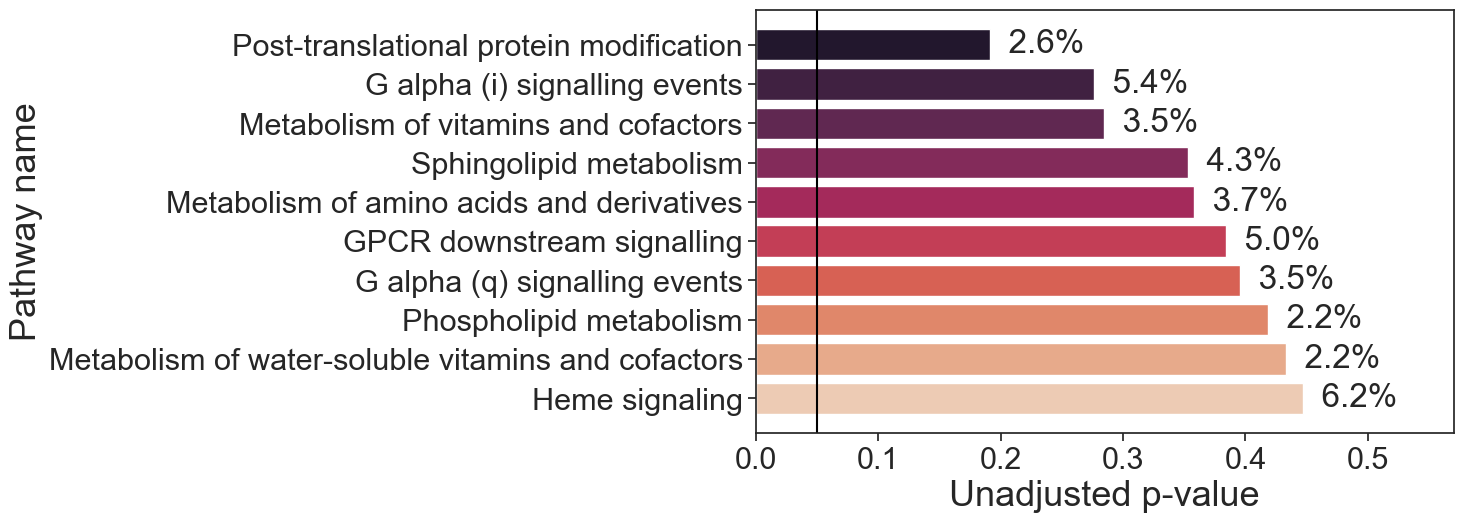

In [35]:

plt.figure(figsize=(9, 5.5))
sns.set(font_scale = 2)

sns.set_style("ticks") # same as "white" but with ticks

ax = sns.barplot(data=top_10_pathways, y="Pathway_name_x", x="combined_pval", orient="h", palette="rocket") #rocket, magma


#Increase space between the bars and the axis
ax.relim()
ax.autoscale_view()



label = []
# percent1 = []
# percent2 = []

#Getting pathway coverage by taking the average of the metabolomic and proteomic pathway coverage (not ideal)
# for i in range(10):
#     pathway1 =  top_10_pathways.Coverage_x[i]
#     num = pathway1.split('/')
#     percent1 = (int(num[0]) / int(num[1])) *100
#     print(percent1)

#     pathway2 =  top_10_pathways.Coverage_y[i]
#     num = pathway2.split('/')
#     percent2 = (int(num[0]) / int(num[1])) *100
#     print(percent2)

#     percent = (percent1+percent2)/2
#     print(percent)
#     label.append("  "+ str(round(percent,1))+ '%')

# print(label)


#Getting pathway coverage by using the Reactome pathway definitions concatenated together
for i in range(10):
    pathway_nam = top_10_pathways.iloc[i,0]
    
    num_in_df = len(filtered_dict[pathway_nam])
    num_whole_pathway = len(pathways_dict[pathway_nam])

    percent = (num_in_df/num_whole_pathway) * 100

    label.append("  "+ str(round(percent,1))+ '%')

ax.bar_label(ax.containers[0], labels=label)

#plt.title('ORA for integrated data',fontsize=22,pad=10)
plt.xlabel('Unadjusted p-value',fontsize=26)
plt.ylabel('Pathway name',fontsize=26) 
plt.xlim(0, 0.57);

plt.axvline(0.05, c="black")

#plt.savefig( '../Figures/integrated_ORA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Gene-set Enrichment Analysis

In [ ]:
gsea_res = sspa.sspa_gsea(df.iloc[:,:-2], df["Group"], reactome_pathways)

In [ ]:
display(gsea_res.sort_values(by="P-adjust FDR")) #0.54 is the lowest for metabolomic, 0.056 for proteomic
#display(gsea_res.sort_values(by="P-value"))

In [ ]:
#Change name to have a line break otherwise it won't fit on the plot
gsea_res.Pathway_name[0] = 'Regulation of Insulin-like Growth Factor (IGF) transport and \n uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)'

In [ ]:
top_10_pathways_gsea

In [ ]:
from matplotlib.lines import Line2D #To colour the bar by enrichment

top_10_pathways_gsea = gsea_res.sort_values(by="P-value").iloc[0:10, :]
plt.figure(figsize=(10, 7))

sns.set(font_scale = 2) #sns.set(font_scale = 1.2) for metabolomic because of long label
sns.set_style("ticks") # same as "white" but with ticks

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_10_pathways_gsea['NES']]
ax = sns.barplot(data=top_10_pathways_gsea, y="Pathway_name", x="P-value", orient="h", palette=bar_color)

#Increase space between the bars and the axis
ax.relim()
ax.autoscale_view()



label = []
for pathway in top_10_pathways_gsea["Entity %"]:
    label.append("  "+ pathway)

print(label)

ax.bar_label(ax.containers[0], labels=label)

#plt.title('GSEA for proteomic data',fontsize=22,pad=10)
plt.xlabel('Unadjusted p-value',fontsize=26)
plt.ylabel('Pathway name',fontsize=26) ;

plt.axvline(0.05, c="black")

# add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'],loc="upper right")

#plt.savefig( '../Figures/metabolomic_GSEA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

For integrated data, take the two GSEA results and combine the p-values with Fisher's method, which is what is commonly done (See Maghsoudi et al., 2021 for examples):

In [ ]:
metabolomic_gsea = gsea_res.sort_values(by="P-value")
metabolomic_gsea = metabolomic_gsea.set_index(['Pathway_ID'])

In [ ]:
proteomic_gsea = gsea_res.sort_values(by="P-value")
proteomic_gsea = proteomic_gsea.set_index(['Pathway_ID'])

In [ ]:
metabolomic_gsea

In [ ]:
proteomic_gsea

In [ ]:
result = metabolomic_gsea.merge(proteomic_gsea, how='inner',right_index=True, left_index = True)
result[:5]

In [ ]:
result["combined_pval"] = 0

In [ ]:
for i in range(len(result.index)):
    ID_list = [result["P-value_x"][i],result["P-value_y"][i]]
    print(ID_list)
    test_stat,pval = scipy.stats.combine_pvalues(ID_list, method='fisher',weights=None)
    print(pval)
    result["combined_pval"][i] = pval


In [ ]:
#Obtain pathway coverage for the top 10 results
df = pd.read_csv("../Data/Su_integrated_data.csv", index_col=0)
reactome_pathways = pd.read_csv("../Data/Reactome_multi_omics_ChEBI_Uniprot.csv", index_col=0,dtype="str") #Dtype warning because in some columns, some values are in string format whereas some are in integer format, that's why I specify dtype="str"
kpca_scores = sspa.sspa_kpca(df.iloc[:,:-2], reactome_pathways)


#Convert pathway ID to name
root_path = pd.read_excel('../Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Using Sara's code, remove root pathways
kpca_scores = kpca_scores.drop(columns = list(set(root_pathway_names) & set(kpca_scores.columns)))



#Filter out the molecules in the pathways that are not present in the dataset
#Obtain all unique values in dataset
compounds_present = list(df.columns[:-2])
filtered_dict = {} 

#Obtain pathways and corresponding molecules for all Reactome pathways, store as dictionary
orig_dict = sspa.utils.pathwaydf_to_dict(reactome_pathways)

#Filter out dictionary to retain only the pathways that remain after kPCA
my_keys = kpca_scores.columns
pathways_dict = {key: orig_dict[key] for key in my_keys}


#My code adapted from Cecilia's
#If the key values are not part of the compounds in dataset then remove
for key,value in pathways_dict.items():
    new_val = [item for item in value if item in compounds_present]
    if len(new_val) >= 2: #at least two compounds in the pathway
        filtered_dict[key] = new_val

In [ ]:
from matplotlib.lines import Line2D

top_10_pathways_gsea = result.sort_values(by="combined_pval").iloc[0:10, :]
plt.figure(figsize=(10, 7))

sns.set(font_scale = 2) #sns.set(font_scale = 1.2) for metabolomic because of long label
sns.set_style("ticks") # same as "white" but with ticks

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_10_pathways_gsea['NES_x']]
ax = sns.barplot(data=top_10_pathways_gsea, y="Pathway_name_x", x="combined_pval", orient="h", palette=bar_color)

#Increase space between the bars and the axis
ax.relim()
ax.autoscale_view()


label=[]
# for i in range(10):
#     pathway1 =  top_10_pathways_gsea["Entity %_x"][i][:-1]
    
#     pathway2 =  top_10_pathways_gsea["Entity %_y"][i][:-1]

#     percent = (float(pathway1)+float(pathway2))/2
#     print(percent)
#     label.append("  "+ str(round(percent,1))+ '%')

# print(label)

for i in range(10):

    pathway_nam = top_10_pathways_gsea.index[i]
    
    num_in_df = len(filtered_dict[pathway_nam])
    num_whole_pathway = len(pathways_dict[pathway_nam])

    percent = (num_in_df/num_whole_pathway) * 100

    label.append("  "+ str(round(percent,1))+ '%')


print(label)



ax.bar_label(ax.containers[0], labels=label)

#plt.title('GSEA for integrated data',fontsize=22, pad=10)
plt.xlabel('Unadjusted p-value',fontsize=26)
plt.ylabel('Pathway name',fontsize=26) 
plt.xlim(0, 0.21);

plt.axvline(0.05, c="black")

#Add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'],loc="upper right")


#plt.savefig( '../Figures/integrated_GSEA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')